<a href="https://colab.research.google.com/github/TeinkBR/1D_harmonic_oscillator/blob/main/Poschl_Teller_potential_hole_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploring  Poschl-Teller potential hole using our harmonic basis

In [ ]:
# First load the numpy/scipy/matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
import pickle
#load interactive widgets
import ipywidgets as widgets
from scipy import interpolate
from math import exp,factorial                          #gaussian quadrature method                        
from scipy.special import hermite
from sympy import diff, integrate, exp          
from scipy.misc import derivative              # import from scipy derivative 
# Import hermite polynomials and factorial to use in normalization factor
from scipy.special import hermite
#If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina'

from numpy import linalg as LA

%matplotlib inline



The Poschl Teller eigenvec looks like:
\begin{equation}
V(x)=-\frac{\hbar^{2}}{2 m} \alpha^{2} \frac{\lambda(\lambda-1)}{\cosh ^{2} \alpha x}
\end{equation}

We are going to test our class function scheme on this potential 

Because we used the scaling for our harmornic oscillator basis (for details please see overleaf documents), our actual arguments here instead of $x$ should be $\tilde{x}$.And from overleaf equation (16)(17):
\begin{align}
    x & = \tilde{x} b \ , \\ 
   \hat{H}=-\frac{\hbar^{2}}{2 m} \frac{d^{2}}{d(\tilde{x}b)^{2}}+\frac{1}{2} m \omega^{2} (\tilde{x}b)^{2}\\
    \tilde{H}(\tilde{x})=\frac{\hat{H}}{\omega} & = - \frac{1}{2} \frac{1}{m \omega b^2 } \frac{d^2}{ d \tilde{x}^2 }  + \frac{1}{2} m \omega b^2 \tilde{x}^2 \notag \\ 
    & =  - \frac{1}{2} \frac{d^2}{ d \tilde{x}^2 }  + \frac{1}{2}  \tilde{x}^2 \ . 
\end{align}
.

\begin{equation}
    \hat{H}=\tilde{H}\omega
\end{equation}

Our Hamiltonian in this should be:

\begin{equation}
x = \tilde{x} b 
\end{equation}
\begin{equation}
\hat{H}=-\frac{\hbar^{2}}{2 m} \frac{d^{2}}{d(\tilde{x}b)^{2}}-V(x)=-\frac{\hbar^{2}}{2 m} \frac{d^{2}}{d(\tilde{x}b)^{2}}-\frac{\hbar^{2}}{2 m} \alpha^{2} \frac{\lambda(\lambda-1)}{\cosh ^{2} \alpha \tilde x b}
\end{equation}

\begin{equation}
\tilde{H}(\tilde{x})=\frac{\hat{H}}{\omega} = - \frac{1}{2} \frac{1}{ m \omega b^2 } \frac{d^2}{ d \tilde{x}^2 }  -\frac{1}{2 m}\frac{ \alpha^{2}}{\omega} \frac{\lambda(\lambda-1)}{\cosh ^{2} \alpha \tilde x b}
\end{equation}
Since we know $b=\frac{1}{\sqrt{\omega m}}$, by replacing the value in our hamiltonian with it and also treating $\hbar$ as 1.
\begin{equation}
 \tilde{H}(\tilde{x})=\frac{\hat{H}}{\omega}=  - \frac{1}{2} \frac{d^2}{ d \tilde{x}^2 }  -\frac{1}{2} \alpha^{2} b^{2} \frac{\lambda(\lambda-1)}{\cosh ^{2} \alpha \tilde x b} 
\end{equation}

Also we have:
\begin{equation}
\hbar c=200 MeV fm
\end{equation}
We had incoporated our $\hbar$ into our $b$, with $b=\frac{\hbar}{\sqrt{ m\omega}}$

In [ ]:
class Poschl_Teller_truncation_scheme:
    
    def __init__(
        self, mesh,length,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha):     #initialize class function with 
        #with variables that we are going to use a lot
        self.e_max=e_max       # energy level we want to input
        
        self.omega=omega
        
        self.length=length
        
        self.starting_position=-length/2 #starting position of gaussian quadrature
        
        self.ending_position=length/2   # ending poistion of gaussian quadrature
        
        self.mesh=mesh  # initializing number of meshpoints
        
        #self.ground_state_energy=self.strong_interaction_eigenval[0]
        
        self.hbar=hbar
        
        self.lambda_coeff=lambda_coeff
        
        self.alpha=alpha
        
        self.Poschl_Teller_mass=Poschl_Teller_mass
        #### scaling factor b=1/sqrt(omega*mass)
        self.scaling_factor_b=self.hbar/np.sqrt(self.Poschl_Teller_mass*self.omega)


        
        self.meshpoint,self.weight = np.polynomial.legendre.leggauss(self.mesh) 
    
        # defining meshpoint and weight for gaussian quadrature
        
        self.h=(self.ending_position-self.starting_position)/2
       
        self.median=(self.ending_position+self.starting_position)/2
    
        self.meshpoint=self.meshpoint*self.h+self.median 
         
        #position of our wave function and 
        
   
        
        # energy level for first wave function
        
        #from 0 to the highest emax
        self.energy_level=np.arange(0,self.e_max) #energy level for second wave function
    
        self.basis_wave_function=np.zeros((self.e_max,len(self.meshpoint))) # wavefunction basis space
        
        self.second_derivative=np.zeros((self.e_max,len(self.meshpoint)))
        # initiailize a rectangular space for second derivative of our basis wave function
        
        self.interpolation_wave_function=[]
    
  
        self.Normalization=[]
        
        self.wave_function=[]
        
        self.Poschl_Teller_potential=np.zeros(len(self.meshpoint))

        self.Poschl_Teller_potential_matrix=np.zeros((self.e_max,self.e_max))
       
        self.Hamiltonian_p_square=np.zeros((self.e_max,self.e_max))
        
        self.Hamiltonian_r_square=np.zeros((self.e_max,self.e_max))
        
        
        
        self.Normalization_check=np.zeros(e_max)
        for i in self.energy_level:
           # for j in self.energy_level:
                
            
            
    
            Hr=hermite(self.energy_level[i])(self.meshpoint)
          
        
            self.Normalization.append(1./np.sqrt(
                    np.sqrt(np.pi)*2**self.energy_level[i]*factorial(self.energy_level[i])))
            
            self.wave_function.append(self.Normalization[i]*hermite(
                 self.energy_level[i])(self.meshpoint)*np.exp(-0.5*self.meshpoint**2))
        
            self.wave_function_coefficient=1./np.sqrt(
                    np.sqrt(np.pi)*2**self.energy_level[i]*factorial(self.energy_level[i]))
            
            
            
            self.basis_wave_function[i]=self.wave_function_coefficient*hermite(i)(
                    self.meshpoint)*np.exp(-0.5*self.meshpoint**2) 
            
        
            
            self.Normalization_check[i]=self.h*np.sum(
                    self.weight*self.basis_wave_function[i]*self.basis_wave_function[i])
     
            
            self.interpolation_wave_function.append(interpolate.interp1d(
                self.meshpoint,self.basis_wave_function[i],kind="cubic",fill_value="extrapolate"))
                
        ## using known analytical hamiltonian to fill the p squared and r squared
        
        for index1 in self.energy_level: ## index 1= n prime, index2= n in the overleaf note
            for index2 in self.energy_level :
                if (index1 == index2) :
                
                    self.Hamiltonian_p_square[index1][index2]= 0.25*(2*index2+1)
                    
            
                elif (index1 == index2-2):
                
                
                    self.Hamiltonian_p_square[index1][index2]= -0.25*np.sqrt(index2*(index2-1))
            
                elif (index1 == index2+2):
                
                    self.Hamiltonian_p_square[index1][index2]= -0.25*np.sqrt((index2+2)*(index2+1))
            
                else:
                    self.Hamiltonian_p_square[index1][index2]=0.      
    
        for index1 in self.energy_level:
            for index2 in self.energy_level: #note: index1,index2 is the energy level 1 and energy level 2 in previous cell
            
                if (index1 == index2):
                
                    self.Hamiltonian_r_square[index1][index2] = 0.25*(2*index2+1)
                
                #print("index1" ,index1,"index2",index2,"Matrix_r",Matrix_r_square)
                #print()
                
                elif (index1 == index2-2):
                
                    self.Hamiltonian_r_square[index1][index2] = 0.25*np.sqrt(index2*(index2-1))
            
                elif (index1 == index2+2):
                
                    self.Hamiltonian_r_square[index1][index2] = 0.25*np.sqrt((index2+2)*(index2+1))
                
                else:
                
                    self.Hamiltonian_r_square[index1][index2] = 0         
    
        
 
        
        
    
        
        
            
        self.Poschl_Teller_potential=-(1/2)*(self.alpha*self.scaling_factor_b)**2*self.lambda_coeff*(
                self.lambda_coeff-1)/(np.cosh(self.scaling_factor_b*self.alpha*self.meshpoint)**2)                 
        
        
        
   
        
        for i in self.energy_level:
            for j in self.energy_level:
                self.Poschl_Teller_potential_matrix[i][j]=self.h*np.sum(
                    self.weight*self.basis_wave_function[i]*
                        self.Poschl_Teller_potential*self.basis_wave_function[j])
                
        
        self.Poschl_Teller_eigenval,self.Poschl_Teller_eigenvec=LA.eigh(
              self.Poschl_Teller_potential_matrix+self.Hamiltonian_p_square)
       
       
        self.Poschl_Teller_plot=self.Poschl_Teller_eigenvec.T@self.basis_wave_function
       
        
        self.Eigenvalue_p_square,self.Eigenvec_p_square=LA.eigh(self.Hamiltonian_p_square)        
                
                
        
        

Here we used the analytical solution of the Poschl-Teller potential hole:

\begin{equation}
E_{n}=-\frac{\hbar^{2} \alpha^{2}}{2 m}(\lambda-1-n)^{2} ; \quad n \leq \lambda-1
\end{equation}

where for even:
\begin{equation}
\frac{\chi}{\alpha}=\lambda-1-2 n
\end{equation}
for odd:
\begin{equation}
\frac{\chi}{\alpha}=\lambda-2-2 n
\end{equation}
to check how close our numerical result is to our analytical result


We now program the analytical solution for Porsch Teller hole to commpare it with our numerical ones

In [ ]:
Porsch_teller_tolerance=1e-6
mesh=100
length=10
starting_position=-length/2
ending_position=length/2
e_max=60
omega=40
hbar=197.3
Poschl_Teller_mass=940
lambda_coeff=3
alpha=1

In [ ]:
n=np.arange(0,e_max,1)
Energy_n=-(hbar*alpha*(lambda_coeff-1-n))**2/(2*Poschl_Teller_mass)
print("ground state",Energy_n)

ground state [-8.28240213e+01 -2.07060053e+01 -0.00000000e+00 -2.07060053e+01
 -8.28240213e+01 -1.86354048e+02 -3.31296085e+02 -5.17650133e+02
 -7.45416191e+02 -1.01459426e+03 -1.32518434e+03 -1.67718643e+03
 -2.07060053e+03 -2.50542664e+03 -2.98166477e+03 -3.49931490e+03
 -4.05837704e+03 -4.65885120e+03 -5.30073736e+03 -5.98403554e+03
 -6.70874572e+03 -7.47486792e+03 -8.28240213e+03 -9.13134835e+03
 -1.00217066e+04 -1.09534768e+04 -1.19266591e+04 -1.29412533e+04
 -1.39972596e+04 -1.50946779e+04 -1.62335082e+04 -1.74137505e+04
 -1.86354048e+04 -1.98984711e+04 -2.12029494e+04 -2.25488398e+04
 -2.39361421e+04 -2.53648565e+04 -2.68349829e+04 -2.83465213e+04
 -2.98994717e+04 -3.14938341e+04 -3.31296085e+04 -3.48067949e+04
 -3.65253934e+04 -3.82854038e+04 -4.00868263e+04 -4.19296608e+04
 -4.38139073e+04 -4.57395658e+04 -4.77066363e+04 -4.97151188e+04
 -5.17650133e+04 -5.38563198e+04 -5.59890384e+04 -5.81631689e+04
 -6.03787115e+04 -6.26356661e+04 -6.49340327e+04 -6.72738113e+04]


# fix omega, e_max, Poschl_teller_mass, etc. vary integration limit, search until tolerance (o~10^-6)

We are going to use tolerance function here


In [ ]:
## attempt a single loop with only mesh

Porsch_teller_tolerance_mesh=1e-14
length_0=5
e_max=40
omega=40
hbar=197.3
Poschl_Teller_mass=940
length_0=2
lambda_coeff=3
alpha=1
mesh_0=10
#i=np.arange(len(mesh_list))
mesh_list=np.arange(mesh_0,1000,10)
print('mesh_list',mesh_list)


for mesh in mesh_list:
  

    new_mesh_class=Poschl_Teller_truncation_scheme(
        mesh,length_0,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
   
    new_mesh_class_increase=Poschl_Teller_truncation_scheme(
        mesh+100,length_0,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
    
    difference_ratio_mesh=np.abs((
        new_mesh_class_increase.Poschl_Teller_eigenval[0]-
        new_mesh_class.Poschl_Teller_eigenval[0])/new_mesh_class.Poschl_Teller_eigenval[0])
            
    print('mesh',mesh)
    print('difference_ratio_mesh',difference_ratio_mesh)
    
    if (difference_ratio_mesh <Porsch_teller_tolerance_mesh):
        break
        
        print('difference_ratio_mesh after break loop',difference_ratio_mesh)
                
        print('eigenenergy after loop',new_mesh_class_increase.Poschl_Teller_eigenval[0])


mesh_list [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360
 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540
 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720
 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900
 910 920 930 940 950 960 970 980 990]
mesh 10
difference_ratio_mesh 1.087341046599576e-06
mesh 20
difference_ratio_mesh 2.64406790876147e-15


In [ ]:
## seperately write for loop for length
Porsch_teller_tolerance_length=1e-12
length_0=5
e_max=40
omega=40
hbar=197.3
Poschl_Teller_mass=940
length_0=2
lambda_coeff=3
alpha=1
mesh_0=1000
#i=np.arange(len(mesh_list))
length_list=np.arange(length_0,20,1)
print('length_list',length_list)


for length in length_list:
  

    new_length_class=Poschl_Teller_truncation_scheme(
        mesh_0,length,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
   
    new_length_class_increase=Poschl_Teller_truncation_scheme(
        mesh_0,length+1,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
    
    difference_ratio_length=np.abs((
        new_length_class_increase.Poschl_Teller_eigenval[0]-
        new_length_class.Poschl_Teller_eigenval[0])/new_length_class.Poschl_Teller_eigenval[0])
            
    print('length',length)
    print('difference_ratio_mesh',difference_ratio_length)
    
    if (difference_ratio_length <Porsch_teller_tolerance_length):
        break
        
        print('difference_ratio_mesh after break loop',difference_ratio_length)
                
        print('eigenenergy after loop',new_length_class_increase.Poschl_Teller_eigenval[0])

length_list [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
length 2
difference_ratio_mesh 0.02537434133402733
length 3
difference_ratio_mesh 0.0018163577567831594
length 4
difference_ratio_mesh 0.00010253921000156533
length 5
difference_ratio_mesh 5.177899267816444e-06
length 6
difference_ratio_mesh 2.508704717490495e-07
length 7
difference_ratio_mesh 1.1947988695869739e-08
length 8
difference_ratio_mesh 5.635271032771466e-10
length 9
difference_ratio_mesh 2.7184532570879364e-11
length 10
difference_ratio_mesh 1.228076003918136e-12
length 11
difference_ratio_mesh 6.777366699924108e-14


In [ ]:
## Now we combine two loop into one nested loop together

## seperately write for loop for length
Porsch_teller_tolerance_length=1e-12
length_0=5
e_max=40
omega=100
hbar=197.3
Poschl_Teller_mass=940
length_0=2
lambda_coeff=3
alpha=1
mesh_0=10
mesh_list=np.arange(mesh_0,1000,10)
length_list=np.arange(length_0,20,1)
print('length_list',length_list)
Poschl_Teller_length_list=[]
Porsch_Teller_gs_energy_length=[]
Porsch_Teller_gs_energy_mesh=[]
Poschl_Teller_mesh_list=[]


for length in length_list:
  

    new_length_class=Poschl_Teller_truncation_scheme(
        mesh_0,length,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
   
    new_length_class_increase=Poschl_Teller_truncation_scheme(
        mesh_0,length+1,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
    
    difference_ratio_length=np.abs((
        new_length_class_increase.Poschl_Teller_eigenval[0]-
        new_length_class.Poschl_Teller_eigenval[0])/new_length_class.Poschl_Teller_eigenval[0])
    
    Porsch_Teller_gs_energy_length.append(new_length_class_increase.Poschl_Teller_eigenval[0])    
    Poschl_Teller_length_list.append(new_length_class_increase.length)

            
    print('length',length)
    print('difference_ratio_mesh',difference_ratio_length)
    
    for mesh in mesh_list:
        
        new_mesh_class=Poschl_Teller_truncation_scheme(
            mesh,length_0,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
   
        new_mesh_class_increase=Poschl_Teller_truncation_scheme(
            mesh+10,length_0,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
    
        difference_ratio_mesh=np.abs((
            new_mesh_class_increase.Poschl_Teller_eigenval[0]-
            new_mesh_class.Poschl_Teller_eigenval[0])/new_mesh_class.Poschl_Teller_eigenval[0])
        
        Poschl_Teller_mesh_list.append(new_mesh_class_increase.mesh)   
        Porsch_Teller_gs_energy_mesh.append(new_mesh_class_increase.Poschl_Teller_eigenval[0])
    
        print('mesh',mesh)
        print('difference_ratio_mesh',difference_ratio_mesh)
    
        if (difference_ratio_mesh <Porsch_teller_tolerance_mesh):
            
            
            
            print('difference_ratio_mesh after break loop',difference_ratio_mesh)
            
            print('eigenenergy after loop',new_mesh_class_increase.Poschl_Teller_eigenval[0])
            break
    if (difference_ratio_length <Porsch_teller_tolerance_length):
        
        print('difference_ratio_mesh after break loop',difference_ratio_length)

        break
        
print('difference_ratio_mesh after break loop',difference_ratio_length)
                
print('eigenenergy after loop',new_length_class_increase.Poschl_Teller_eigenval[0])



length_list [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
length 2
difference_ratio_mesh 0.12715251779520315
mesh 10
difference_ratio_mesh 1.7661792994936451e-07
mesh 20
difference_ratio_mesh 2.033511053400014e-15
difference_ratio_mesh after break loop 2.033511053400014e-15
eigenenergy after loop -0.7097526859269003
length 3
difference_ratio_mesh 0.031391119888533575
mesh 10
difference_ratio_mesh 1.7661792994936451e-07
mesh 20
difference_ratio_mesh 2.033511053400014e-15
difference_ratio_mesh after break loop 2.033511053400014e-15
eigenenergy after loop -0.7097526859269003
length 4
difference_ratio_mesh 0.05248203113640041
mesh 10
difference_ratio_mesh 1.7661792994936451e-07
mesh 20
difference_ratio_mesh 2.033511053400014e-15
difference_ratio_mesh after break loop 2.033511053400014e-15
eigenenergy after loop -0.7097526859269003
length 5
difference_ratio_mesh 0.05867081498095511
mesh 10
difference_ratio_mesh 1.7661792994936451e-07
mesh 20
difference_ratio_mesh 2.033511053400014

Poschl_Teller_mesh_list [20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30, 20, 30]
Porsch_Teller_gs_energy_mesh [-0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003, -0.7097526859269018, -0.7097526859269003]


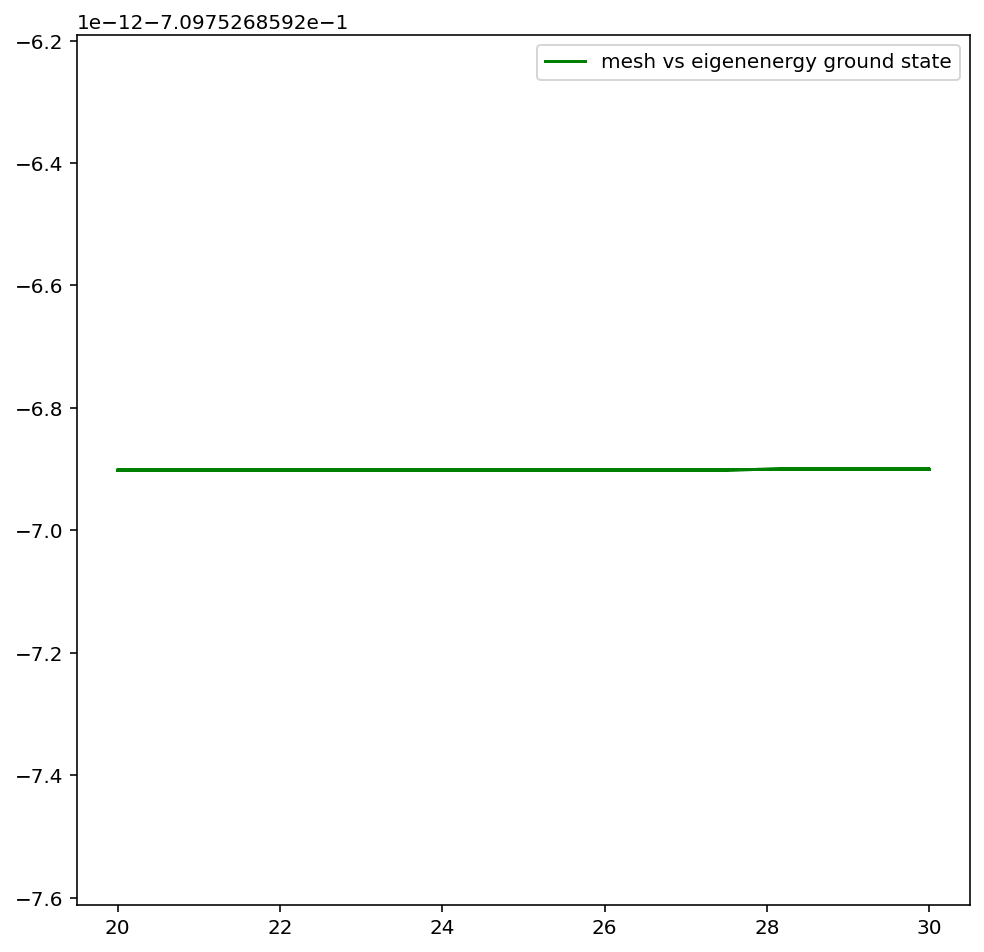

In [ ]:
print('Poschl_Teller_mesh_list',Poschl_Teller_mesh_list)
print('Porsch_Teller_gs_energy_mesh',Porsch_Teller_gs_energy_mesh)

fig, ax = plt.subplots(figsize=(8,8))        

ax.plot(Poschl_Teller_mesh_list,Porsch_Teller_gs_energy_mesh,'r-',color='green',label='mesh vs eigenenergy ground state') 


ax.legend()




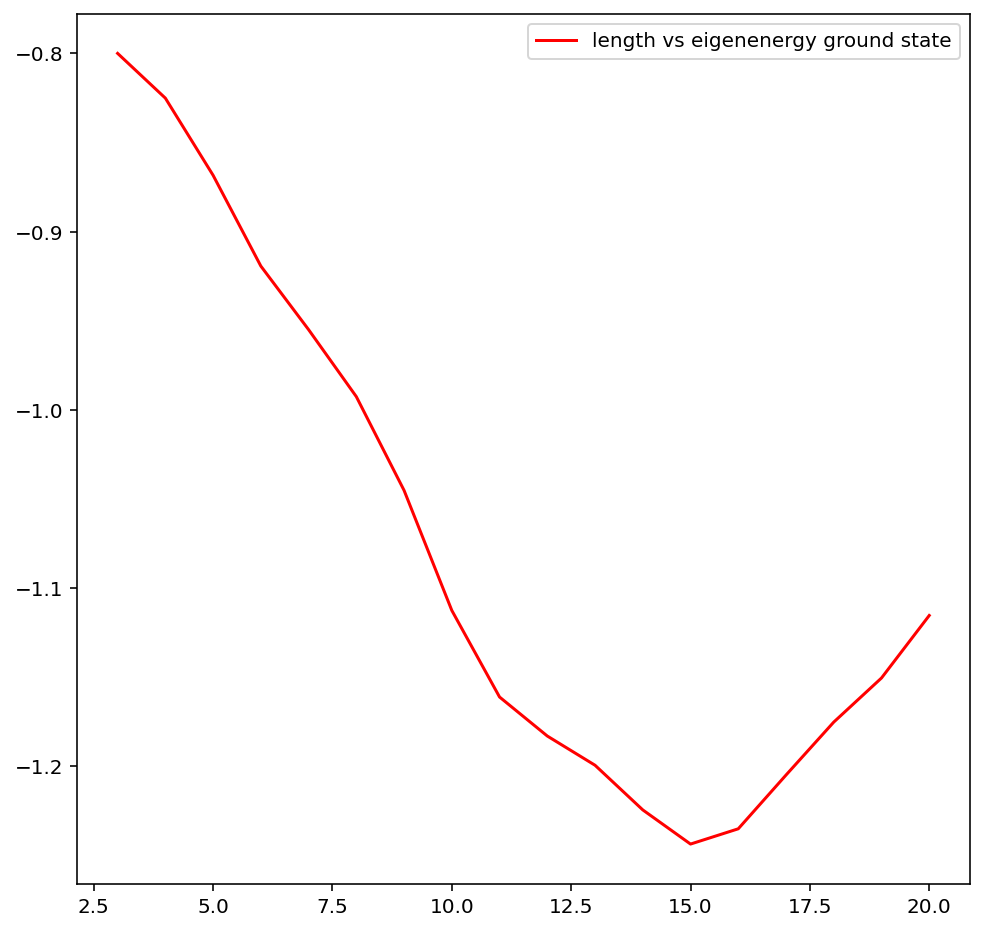

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))        

ax.plot(Poschl_Teller_length_list,Porsch_Teller_gs_energy_length,'r-',color='red',label='length vs eigenenergy ground state') 

ax.legend()


In [ ]:
for mesh in range(10,100000,100):
        
        new_mesh_class=Poschl_Teller_truncation_scheme(
            mesh,length_0,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
   
        new_mesh_class_increase=Poschl_Teller_truncation_scheme(
            mesh+100,length_0,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
    
        difference_ratio_mesh=np.abs((
            new_mesh_class_increase.Poschl_Teller_eigenval[0]-
            new_mesh_class.Poschl_Teller_eigenval[0])/new_mesh_class.Poschl_Teller_eigenval[0])
            
        Poschl_Teller_mesh_list.append(new_mesh_class_increase.Poschl_Teller_eigenval[0])
    
        print('mesh',mesh)
        print('difference_ratio_mesh',difference_ratio_mesh)
    
        if (difference_ratio_mesh <1e-14):
            
            
            
            print('difference_ratio_mesh after break loop',difference_ratio_mesh)
            
            print('eigenenergy after loop',new_mesh_class_increase.Poschl_Teller_eigenval[0])
            break

mesh 10
difference_ratio_mesh 1.7661793010578847e-07
mesh 110
difference_ratio_mesh 2.346358907769247e-15
difference_ratio_mesh after break loop 2.346358907769247e-15
eigenenergy after loop -0.7097526859269002


Streaming output truncated to the last 5000 lines.
e_max 29
ground state energy list -3.9438999657252065
omega 22
e_max 5
ground state energy list -3.6833985126915674
e_max 6
ground state energy list -3.683398512691568
e_max 7
ground state energy list -3.7273503395038716
e_max 8
ground state energy list -3.7273503395038707
e_max 9
ground state energy list -3.7465040869723274
e_max 10
ground state energy list -3.7465040869723265
e_max 11
ground state energy list -3.7554209287237623
e_max 12
ground state energy list -3.755420928723762
e_max 13
ground state energy list -3.7597989602714055
e_max 14
ground state energy list -3.7597989602714086
e_max 15
ground state energy list -3.7620365524025274
e_max 16
ground state energy list -3.762036552402522
e_max 17
ground state energy list -3.76321979928614
e_max 18
ground state energy list -3.7632197992861407
e_max 19
ground state energy list -3.76386355304851
e_max 20
ground state energy list -3.7638635530485076
e_max 21
ground state energy list 

No handles with labels found to put in legend.


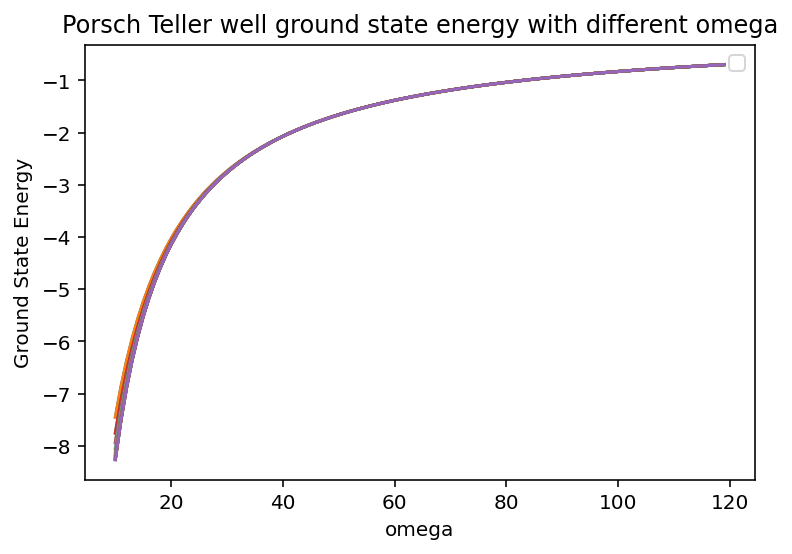

In [ ]:
#def E_gs(e_max_0,e_max_end,omega_0,omega_end):
    ##feeding initial variables to omega and e_max
e_max_0=5
e_max_end=30
omega_0=10
omega_end=120
    
mesh=1000
length=20
d_e_max=1
d_omega=1
gs_class=[]

print('e_max_list',np.arange(e_max_0,e_max_end,d_e_max))
print('omega_list',np.arange(omega_0,omega_end,d_omega))
    
e_max_list=np.arange(e_max_0,e_max_end,d_e_max)
omega_list=np.arange(omega_0,omega_end,d_omega)
    
gs_energy_list=np.empty((len(omega_list),len(e_max_list)),dtype=float)
    
gs_energy_class_list=np.empty((len(omega_list),len(e_max_list)),dtype=object)

for i_omega,omega in enumerate(omega_list):## iterate omega and e_max to generate different ground state energy 
    print('omega',omega)
    for i_e_max,e_max in enumerate(e_max_list):
        print('e_max',e_max)
            
        gs_energy_class_list[i_omega][i_e_max]=(Poschl_Teller_truncation_scheme(
            mesh,length,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha))
            
        gs_energy_list[i_omega][i_e_max]=gs_energy_class_list[i_omega][i_e_max].Poschl_Teller_eigenval[0]
            
        print('ground state energy list',gs_energy_list[i_omega][i_e_max])
    
  
    
    
#plt.plot(gs_energy_list[:,i_e_max],omega_list, 'r', label="$E_{}$={:>8.3f}".format(i_e_max),linewidth=2)
 
    
for i_e_max,e_max in enumerate(e_max_list):

        
    plt.plot(omega_list, gs_energy_list[:,i_e_max] )
   # label
plt.title('Porsch Teller well ground state energy with different omega')
plt.xlabel("omega")
plt.ylabel("Ground State Energy") 
plt.legend()
plt.show()
       # plt.savefig(images_dir+str(num)+"_"+str(split)+"Porsch_Teller_different_omega_emax.pdf")

                


            
#E_gs(10,20,40,45)
#print('gs_energy_list[i_e_max,:]',E_gs(10,20,40,45)
#.gs_energy_list[i_e_max,:]) 
           
    

In [ ]:
gs_energy_list[:,i_e_max]

array([-8.26958502, -4.14105285, -2.76079632, -2.07060032, -1.65648041,
       -1.38040035, -1.1832003 , -1.03530026, -0.92026689, -0.82824018,
       -0.75294557])

In [ ]:
omega_list

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110])

In [ ]:
gs_energy_class_list[0][0].e_max

5

In [ ]:
gs_energy_class_list[0][1].e_max

6

In [ ]:
gs_energy_class_list[0][0].omega

10

In [ ]:
gs_energy_class_list[1][0].omega

20

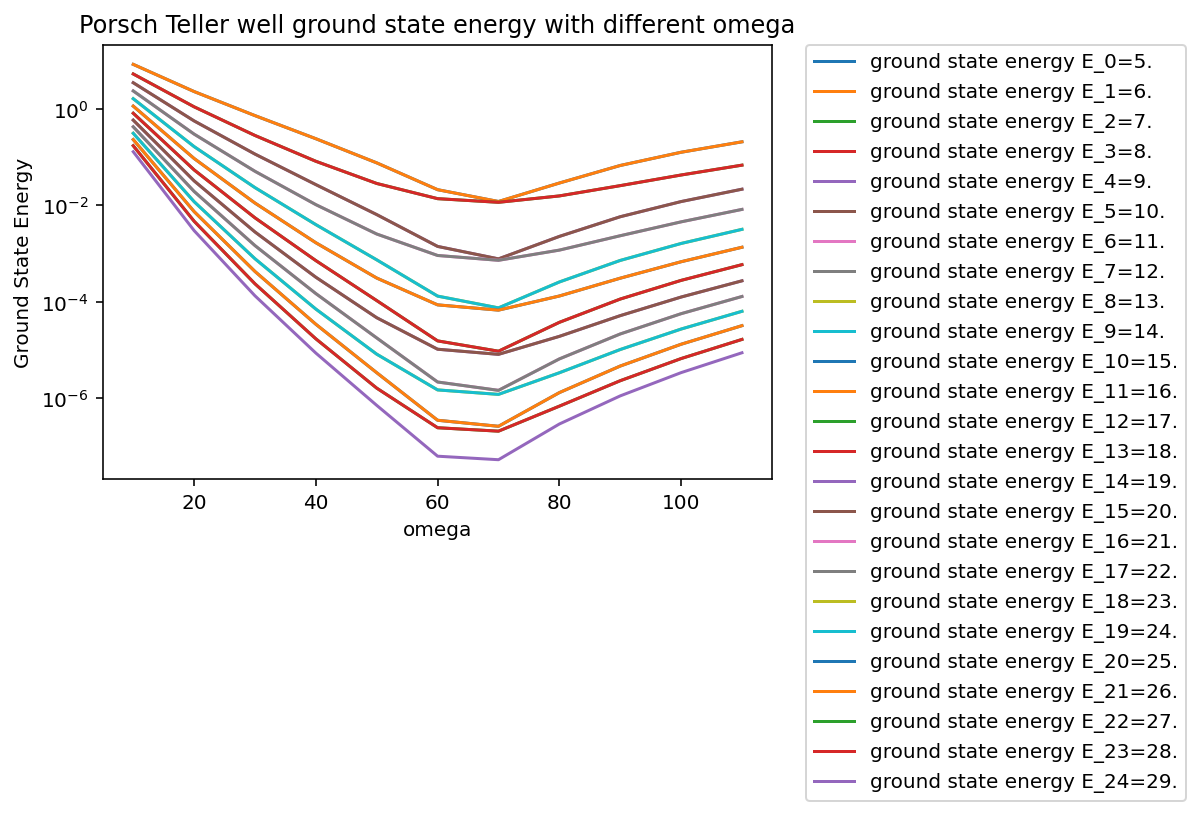

In [ ]:
for i_e_max,e_max in enumerate(e_max_list):

        
    plt.plot(omega_list, gs_energy_list[:,i_e_max]*omega_list-Energy_n[0],label=rf"ground state energy E_{i_e_max}={e_max}.")
    #plt
    plt.yscale('log')
    #plt.legend('gs_energy_list[:,i_e_max]*omega_list-Energy_n[0]',loc="upper left")

   # label
plt.title('Porsch Teller well ground state energy with different omega')
plt.xlabel("omega")
plt.ylabel("Ground State Energy") 
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
print("ground state",Energy_n)

ground state [-8.28240213e+01 -2.07060053e+01 -0.00000000e+00 -2.07060053e+01
 -8.28240213e+01 -1.86354048e+02 -3.31296085e+02 -5.17650133e+02
 -7.45416191e+02 -1.01459426e+03 -1.32518434e+03 -1.67718643e+03
 -2.07060053e+03 -2.50542664e+03 -2.98166477e+03 -3.49931490e+03
 -4.05837704e+03 -4.65885120e+03 -5.30073736e+03 -5.98403554e+03
 -6.70874572e+03 -7.47486792e+03 -8.28240213e+03 -9.13134835e+03
 -1.00217066e+04 -1.09534768e+04 -1.19266591e+04 -1.29412533e+04
 -1.39972596e+04 -1.50946779e+04 -1.62335082e+04 -1.74137505e+04
 -1.86354048e+04 -1.98984711e+04 -2.12029494e+04 -2.25488398e+04
 -2.39361421e+04 -2.53648565e+04 -2.68349829e+04 -2.83465213e+04
 -2.98994717e+04 -3.14938341e+04 -3.31296085e+04 -3.48067949e+04
 -3.65253934e+04 -3.82854038e+04 -4.00868263e+04 -4.19296608e+04
 -4.38139073e+04 -4.57395658e+04 -4.77066363e+04 -4.97151188e+04
 -5.17650133e+04 -5.38563198e+04 -5.59890384e+04 -5.81631689e+04
 -6.03787115e+04 -6.26356661e+04 -6.49340327e+04 -6.72738113e+04]


In [ ]:
## Now we package the prveious double loop search into a function routine, we will use it further in other situations
def length_mesh_search (omega,e_max,input_class):
## define omega and emax as variables since we are going to search omega e_max afterwards

## seperately write for loop for length
  Porsch_teller_tolerance_length=1e-12
  length_0=5
  
  hbar=197.3
  Poschl_Teller_mass=940
  length_0=2
  lambda_coeff=3
  alpha=1
  mesh_0=10
  mesh_list=np.arange(mesh_0,1000,10)
  length_list=np.arange(length_0,20,1)
  #print('length_list',length_list)
  Poschl_Teller_length_list=[]
  Porsch_Teller_gs_energy_length=[]
  Porsch_Teller_gs_energy_mesh=[]
  Poschl_Teller_mesh_list=[]


  for length in length_list:

  

    new_length_class=input_class(
        mesh_0,length,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
   
    new_length_class_increase=input_class(
        mesh_0,length+1,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
    
    difference_ratio_length=np.abs((
        new_length_class_increase.Poschl_Teller_eigenval[0]-
        new_length_class.Poschl_Teller_eigenval[0])/new_length_class.Poschl_Teller_eigenval[0])
    
    Porsch_Teller_gs_energy_length.append(new_length_class_increase.Poschl_Teller_eigenval[0])    
    Poschl_Teller_length_list.append(new_length_class_increase.length)

    #length_mesh_search.gs_energy_after_search=new_mesh_class_increase.Poschl_Teller_eigenval[0]

            
    #print('length',length)
    #print('difference_ratio_mesh',difference_ratio_length)
    
    for mesh in mesh_list:
        
        new_mesh_class=input_class(
            mesh,length_0,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
   
        new_mesh_class_increase=input_class(
            mesh+10,length_0,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha)
    
        difference_ratio_mesh=np.abs((
            new_mesh_class_increase.Poschl_Teller_eigenval[0]-
            new_mesh_class.Poschl_Teller_eigenval[0])/new_mesh_class.Poschl_Teller_eigenval[0])
        
        Poschl_Teller_mesh_list.append(new_mesh_class_increase.mesh)   
        Porsch_Teller_gs_energy_mesh.append(new_mesh_class_increase.Poschl_Teller_eigenval[0])
    
        #print('mesh',mesh)
        #print('difference_ratio_mesh',difference_ratio_mesh)



    
        if (difference_ratio_mesh <Porsch_teller_tolerance_mesh):
            
            
            
            #print('difference_ratio_mesh after break loop',difference_ratio_mesh)
            
            #print('eigenenergy after loop',new_mesh_class_increase.Poschl_Teller_eigenval[0])
            break
    if (difference_ratio_length <Porsch_teller_tolerance_length):
        
        #print('difference_ratio_mesh after break loop',difference_ratio_length)

        break
    
        
    #print('difference_ratio_mesh after break loop',difference_ratio_length)
                
    #print('eigenenergy after loop',new_length_class_increase.Poschl_Teller_eigenval[0])

  return input_class(
      mesh,length,e_max,omega,hbar,Poschl_Teller_mass,lambda_coeff,alpha).Poschl_Teller_eigenval[0]

length_mesh_search(
    omega_0,e_max_0,Poschl_Teller_truncation_scheme)


-7.135853962592941

In [ ]:
Porsch_Teller_gs_energy_e_max=[]
Poschl_Teller_e_max_list=[]
Poschl_Teller_omega_list=[]
Porsch_Teller_gs_energy_omega=[]
Porsch_teller_tolerance_omega=1e-6
Porsch_teller_tolerance_e_max=1e-4
omega_list=np.arange()
for e_max in e_max_list:
  new_e_max_class=length_mesh_search(omega,e_max,Poschl_Teller_truncation_scheme)
  
  new_e_max_class_increase=length_mesh_search(omega,e_max+1,Poschl_Teller_truncation_scheme)
  
  difference_ratio_e_max=np.abs((new_e_max_class_increase-new_e_max_class)/new_e_max_class)
  
  Porsch_Teller_gs_energy_e_max.append(new_e_max_class_increase)    
  
  Poschl_Teller_e_max_list.append(e_max)

  print('E_{max}',e_max)
  
  print('difference_ratio_e_max',difference_ratio_e_max)
  
  for omega in omega_list:
    
    new_omega_class=length_mesh_search(omega,e_max,Poschl_Teller_truncation_scheme)
    
    new_omega_class_increase=length_mesh_search(omega+1,e_max,Poschl_Teller_truncation_scheme)
    
    difference_ratio_omega=np.abs((new_omega_class_increase-new_omega_class)/new_omega_class)
    
    Poschl_Teller_omega_list.append(omega)   
    
    Porsch_Teller_gs_energy_omega.append(new_omega_class_increase)
    
    print('omega',omega)
    print('difference_ratio_omega',difference_ratio_omega)

    if (difference_ratio_mesh <Porsch_teller_tolerance_omega):
      
      print('difference_ratio_omega after break loop',difference_ratio_omega)
      
      print('eigenenergy after loop',new_omega_class_increase)
      
      break
  
  if (difference_ratio_length <Porsch_teller_tolerance_length):
    
    print('difference_ratio_e_max after break loop',difference_ratio_e_max)

    break





E_{max} 5
difference_ratio_e_max 1.5894752068619357e-16
omega 10
difference_ratio_omega 0.06927645563188646
difference_ratio_omega after break loop 0.06927645563188646
eigenenergy after loop -6.64150729215775
E_{max} 6
difference_ratio_e_max 0.026303346234648972
omega 10
difference_ratio_omega 0.06927645563188622
difference_ratio_omega after break loop 0.06927645563188622
eigenenergy after loop -6.64150729215775
E_{max} 7
difference_ratio_e_max 0.0
omega 10
difference_ratio_omega 0.0709293951099595
difference_ratio_omega after break loop 0.0709293951099595
eigenenergy after loop -6.804095771746242
E_{max} 8
difference_ratio_e_max 0.009684194494104376
omega 10
difference_ratio_omega 0.07092939510995963
difference_ratio_omega after break loop 0.07092939510995963
eigenenergy after loop -6.804095771746241
E_{max} 9
difference_ratio_e_max 2.4022762968990074e-16
omega 10
difference_ratio_omega 0.07161074445813692
difference_ratio_omega after break loop 0.07161074445813692
eigenenergy after l